In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 6

# Load the dataset
train_ds = image_dataset_from_directory(
    "/content/project/train",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = image_dataset_from_directory(
    "/content/project/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

# Data augmentation for better generalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Preprocessing Layer
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# EfficientNet model
efficientnet_base = tf.keras.applications.EfficientNetB0(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
efficientnet_base.trainable = False

# ResNet model
resnet_base = tf.keras.applications.ResNet50(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
resnet_base.trainable = False

# Combined model architecture
def build_combined_model():
    input_layer = layers.Input(shape=IMAGE_SIZE + (3,))

    x = data_augmentation(input_layer)
    x = preprocess_input(x)

    # EfficientNet branch
    x1 = efficientnet_base(x)
    x1 = layers.GlobalAveragePooling2D()(x1)

    # ResNet branch
    x2 = resnet_base(x)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # Concatenating outputs
    combined = layers.Concatenate()([x1, x2])
    combined = layers.Dense(256, activation="relu")(combined)
    combined = layers.Dropout(0.5)(combined)
    output_layer = layers.Dense(1, activation="sigmoid")(combined)

    return models.Model(inputs=input_layer, outputs=output_layer)

# Build and compile the model
model = build_combined_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Early Stopping Callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Save the model
model.save("combined_vit_resnet_classifier.h5")


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 800s 248ms/step - accuracy: 0.8550 - loss: 0.3277 - val_accuracy: 0.9403 - val_loss: 0.1551
Epoch 2/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 778s 249ms/step - accuracy: 0.9240 - loss: 0.1898 - val_accuracy: 0.9414 - val_loss: 0.1475
Epoch 3/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 780s 242ms/step - accuracy: 0.9364 - loss: 0.1660 - val_accuracy: 0.9518 - val_loss: 0.1222
Epoch 4/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 801s 241ms/step - accuracy: 0.9398 - loss: 0.1516 - val_accuracy: 0.9520 - val_loss: 0.1215
Epoch 5/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 753s 241ms/step - accuracy: 0.9433 - loss: 0.1432 - val_accuracy: 0.9571 - val_loss: 0.1088
Epoch 6/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 805s 242ms/step - accuracy: 0.9471 - loss: 0.1356 - val_accuracy: 0.9578 - val_loss: 0.1074
625/625 ━━━━━━━

Test Loss: 0.1074
Test Accuracy: 0.9578


TypeError: cannot pickle 'module' object

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ sequential[0][0]       │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3328)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        852,224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,194,728 (115.18 MB)

 Trainable params: 852,481 (3.25 MB)

 Non-trainable params: 27,637,283 (105.43 MB)

 Optimizer params: 1,704,964 (6.50 MB)

In [8]:
model.save("combined_vit_resnet_classifier.keras")


In [10]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("combined_vit_resnet_classifier.keras")

# Verify the model structure
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ sequential[0][0]       │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3328)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        852,224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,194,728 (115.18 MB)

 Trainable params: 852,481 (3.25 MB)

 Non-trainable params: 27,637,283 (105.43 MB)

 Optimizer params: 1,704,964 (6.50 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


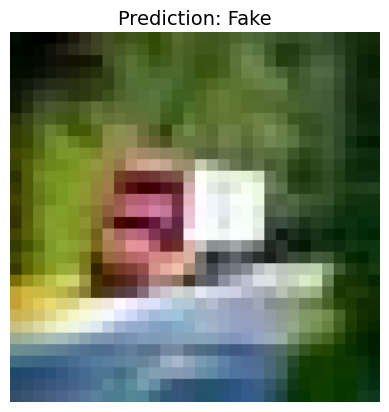

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


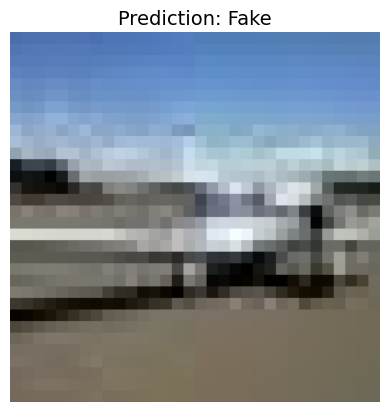

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


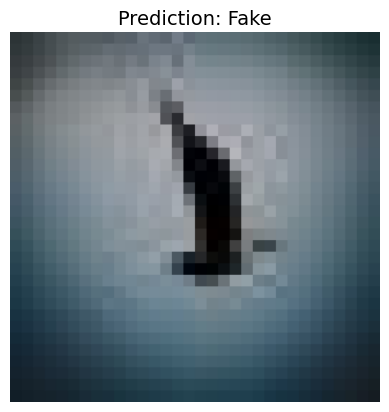

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


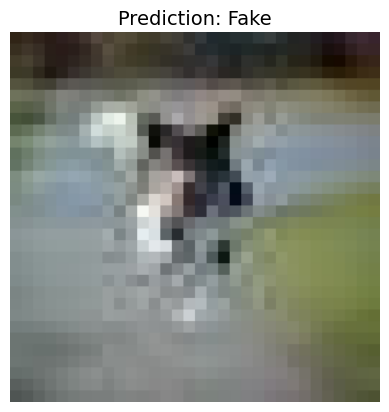

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


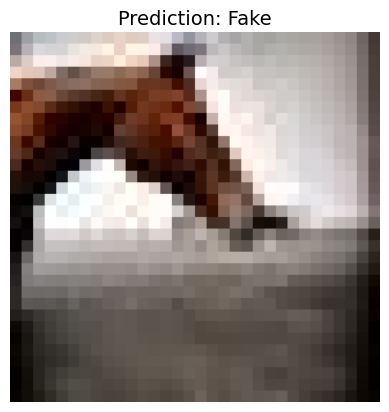

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


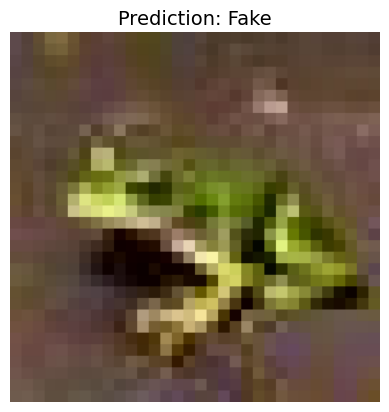

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


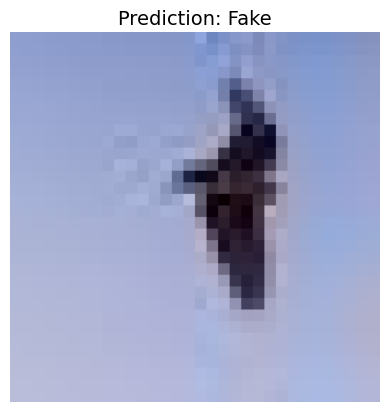

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


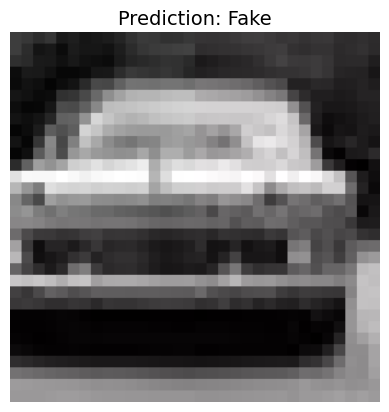

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


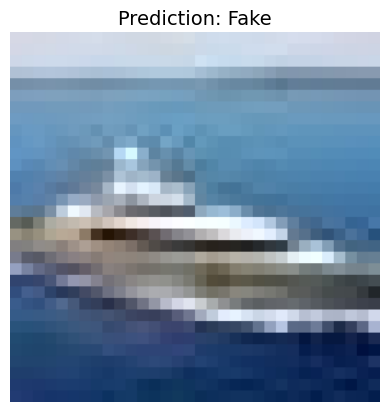

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


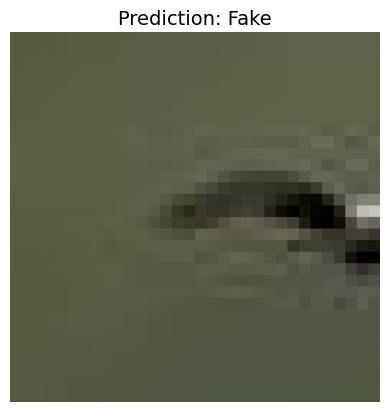

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import random

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image
    return img_array

# Function to display image with prediction
def display_image_with_prediction(img_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Predict using the trained model
    prediction = model.predict(img_array)
    predicted_label = 'Real' if prediction >= 0.5 else 'Fake'

    # Load the image for display
    img = image.load_img(img_path, target_size=IMAGE_SIZE)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.title(f"Prediction: {predicted_label}", fontsize=14)
    plt.show()

# Testing images from the REAL folder
test_image_folder = "/content/project/test/FAKE"

# Get a list of all images in the REAL folder
real_image_paths = [os.path.join(test_image_folder, fname) for fname in os.listdir(test_image_folder) if fname.endswith('.jpg')]

# Select the top 10 images from the REAL folder
top_10_real_images = random.sample(real_image_paths, 10)  # Randomly sample 10 images

# Display each image with its prediction
for img_path in top_10_real_images:
    display_image_with_prediction(img_path)
